**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

*All the text in italics is instructions for filling the template - remove when writing the project report!*

# *Title* 

## Abstract

*Precise summary of the whole report, previews the contents and results. Must be a single paragraph between 100 and 200 words.*



## 1. Introduction

*Background, problem statement, motivation, many references, description of
contents. Introduces the reader to the topic and the broad context within which your
research/project fits*

*- What do you hope to learn from the project?*
*- What question is being addressed?*
*- Why is this task important? (motivation)*

*Keep it short (half to 1 page).*



### 1.1 Problem statement
In this project we want to classify songs into one of 10 genres: 'Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues'. The songs have been transformed into numerical features, describing various sound characteristics. 
### 1.2 Motivation
Human beings perform the same classification task on time series data, so this should at least in theory be possible to do with a machine. However, since the classification task performed on raw data of a sound file would be extremely computationally expensive, it would be interesting to discover whether it would be possible to classify the songs in a heavily compressed format. Furthermore, the computation of the classification would be independent on the song length. This is the format of the dataset of this project; 264 features of different sound characteristics of the whole audio file.



## 2. Data analysis

In [1]:
# Import libraries
import visu_utils as vu
import data_utils as du
import pandas as pd
import numpy as np

We start by importing the data as csv files to Pandas DataFrames. The raw data consists of 4363 datapoints, each with 264 features. All the functions used for data analysis can be found in visu_utils (for visualizing functions) and data_utils (for data processing and transformation functions)

In [2]:
# Import data
data_file = 'kaggle_data/train_data.csv'
labels_file = 'kaggle_data/train_labels.csv'
data, labels = du.Import_Data(data_file, labels_file)

Imported data (4363, 264) and labels (4363, 1).


### 2.1. Label representation
We start by analyzing the distribution of labels of the dataset. The goal would be to have as uniform distribution as possible.

As can be observed below, there are disproportionally many samples of label 1 (Pop/Rock), and a slight overrepresentation of label 2. This might be taken into account in the preprocessing stage. The alternatives of approaching this problem could be: 
1. Augmenting the dataset (e.g. resampling)
2. Modifying the loss function (e.g. by penalizing misclassification of minority classes more)
3. Utilizing ensemble methods (e.g. "bagging")

Frequency of labels in percentage:
Label 1 : 2178 samples, frequency: 49.920 %
Label 2 : 618 samples, frequency: 14.165 %
Label 3 : 326 samples, frequency: 7.472 %
Label 4 : 260 samples, frequency: 5.959 %
Label 5 : 253 samples, frequency: 5.799 %
Label 6 : 214 samples, frequency: 4.905 %
Label 7 : 195 samples, frequency: 4.469 %
Label 8 : 141 samples, frequency: 3.232 %
Label 9 : 92 samples, frequency: 2.109 %
Label 10 : 86 samples, frequency: 1.971 %


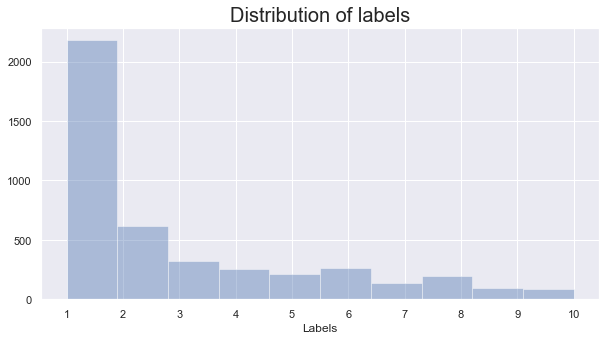

In [3]:
# Histogram of label distribution
vu.label_distribution(labels.values,size=(10,5))

### 2.2. Feature analysis 
#### 2.2.1 Variance 
Next, we will analyze the features. It is important that the features are normalized before calculating the final variance, so that all the resulting variances will be in the same range. With this normalization step it is possible to directly compare the variances. 

4 features with zero-variance were detected. These can directly be dismissed, because they contain no information. A majority (about 40%) of the rest of the features have a variance lower than 0.015. These features might be less significant, but it is hard to say at this stage whether it is worth keeping them for the training. This might be taken into account during the preprocessing. One idea would be to test to drop features with normalized variance below a certain threshold and see how it affects the classification. The benefit of dropping this many features would be great, as the training time could potentially be dramatically reduced. 

Zero variance features removed from data. Input shape: (4363, 264). Output shape: (4363, 260).
10 :th percentile:  0.014831916303804352
20 :th percentile:  0.014837838120658402
30 :th percentile:  0.014838503426721324
40 :th percentile:  0.014842608635116591
50 :th percentile:  0.038657677298818874
60 :th percentile:  0.06610638918252043
70 :th percentile:  0.14190034613989205
80 :th percentile:  0.32928821955729215
90 :th percentile:  0.6004243178683137


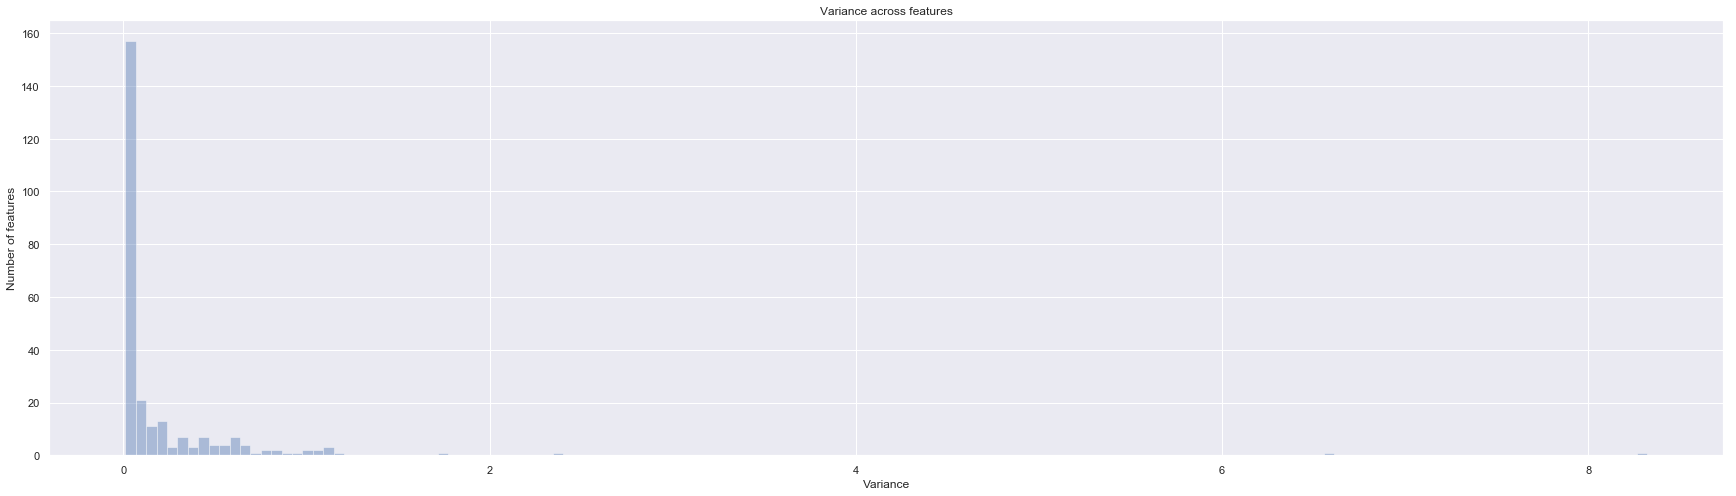

In [4]:
vu.feature_variances(data)

#### 2.2.2 Correlation
Next, let's look at mutual correlation of all the features. This can be visualized with the correlation matrix heat map below. Feature pairs with high enough correlation would indicate that one of them is redundant, and could thus be dismissed.
No features with correlation of 1 were found, but the highest correlation of 0.995 is relatively high. 6 feature pairs with a correlation of higher than 0.995 were found. These might be dismissed (only one of the pairs, of course) during the preprocessing. Again, it might be useful to test the classification after and before dropping the features in order to investigate whether they have any impact on the classification performance.

Zero variance features removed from data. Input shape: (4363, 264). Output shape: (4363, 260).
Largest correlation:  0.9953987162062764
Indeces with stronger correlance than  0.995 :
 [ 14  15  16 110 111 112] 
 [110 111 112  14  15  16]
Correlation of percentile  99 :  0.691365120369371


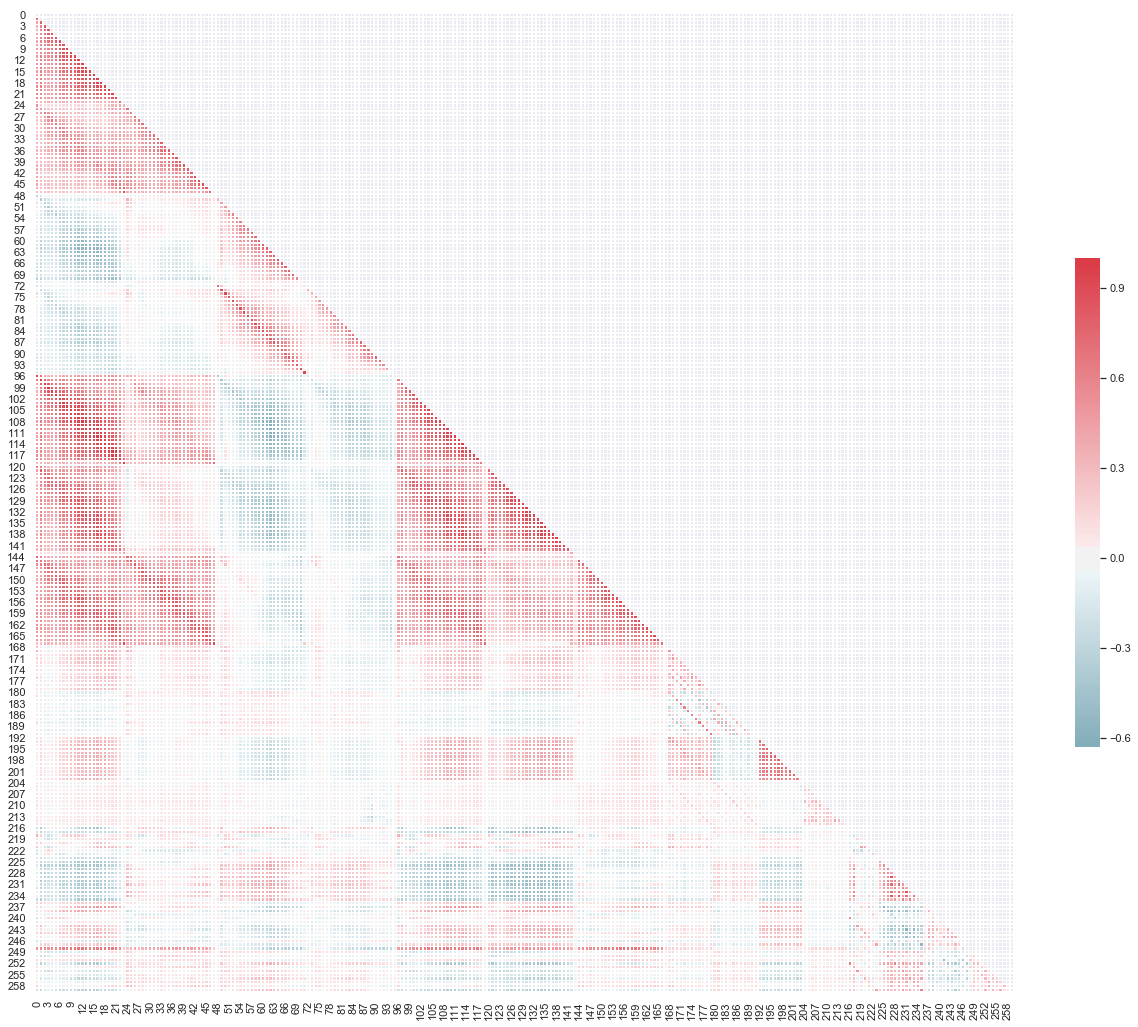

In [5]:
cor_m = vu.feature_correlations(data)

#### 2.2.2 Testing feature importance
Next, we will test removing some features and see whether it has any effect on classification. For this, we will use a quick-and-dirty simplistic XGBoost random forest classifier. At the same time it is a good opportunity to familiarize ourselves with different methods for evaluating classification performance and get a reference score we can compare with more refined models at a later stage. 

First, let's add all the less important features (that is, what we hypothesize are less important) to a list.
At this stage, we have to define a low threshold for variance and high threshold for correlation. We'll use the previous threshold for correlation for now, but allow for some tweaking of the variance threshold.

In [6]:
var_thresh = 0.0146

Finding features with low variance....

In [7]:
low_variances = du.Low_variance(data.values,var_thresh)
low_variances_ = ['f22', 'f23', 'f46', 'f118', 'f119', 'f124', 'f129', 'f140', 'f141', 'f142']
print("Features with lowest variance: ",low_variances)

Zero variance features removed from data. Input shape: (4363, 264). Output shape: (4363, 260).
Features with lowest variance:  [22, 23, 46, 118, 119, 124, 129, 140, 141, 142]



Next, we will do a quick-and-dirty train round with XGBoost to find out a rough estimation of the importance of these features based on the Gini factor

Using TensorFlow backend.


Data successfully split. Test data ratio = 0.3
Minimum importance:  1
Maximum importance:  79
Importance of low variance features:  [7, 9, 9, 5, 2, 19, 12, 13, 13, 10]


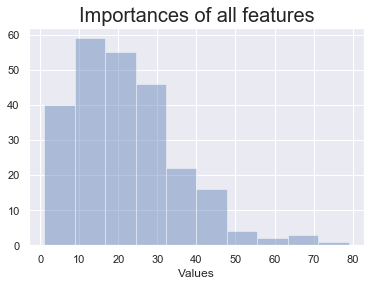

In [8]:
import learning_utils as lu
y = labels.values
X = data.values
X_train, X_test, y_train, y_test = du.Split_Data(X,y)
bst = lu.Learn_XGBoost(X_train,y_train,X_test,y_test,max_depth=500,num_round=50,use_weights=False)
import operator
importances = bst.get_score()
min_importance = importances[min(importances.items(), key=operator.itemgetter(1))[0]]
max_importance = importances[max(importances.items(), key=operator.itemgetter(1))[0]]
print("Minimum importance: ", min_importance)
print("Maximum importance: ", max_importance)
vu.hist(np.fromiter(importances.values(), dtype=float),title="Importances of all features")
low_variance_importance = [importances.get(key) for key in low_variances_]
print("Importance of low variance features: ", low_variance_importance)
importances_sorted = sorted(importances.items(), key=lambda kv: kv[1])
#print(importances_sorted)

The features seem to consist of a very few highly important features, while most of them lie in the low-importance region. 

All low variance features with importance below 10 will be chosen.

We will add the features with higher correlation than 0.995. We'll copy one of the feature list previously calculated.

In [9]:
low_variances = [22, 23, 46, 118, 119]
high_correlations = [14,15,16,110,111,112]

Then we'll merge these lists together. We want to avoid overlapping features with both high correlation and low variance so unique is used.

In [10]:
remove_features = list(np.unique(np.array(low_variances + high_correlations)))

In [11]:
X = data.values
X_reduced = np.delete(X,remove_features,axis=1)
print("Comparing original shape to reduced shape:")
print("Original: ", X.shape)
print("Reduced: ",X_reduced.shape)

Comparing original shape to reduced shape:
Original:  (4363, 264)
Reduced:  (4363, 253)


Next, both datasets, original and reduced, are trained with identical machine learning model. 

Training and testing the original features:


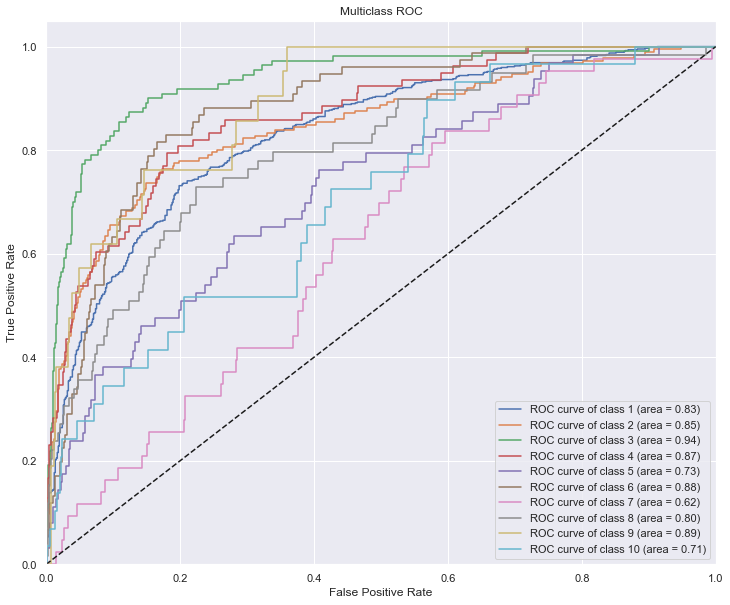

              precision    recall  f1-score   support

           1       0.69      0.84      0.76       644
           2       0.60      0.56      0.58       186
           3       0.62      0.61      0.61       110
           4       0.49      0.36      0.41        78
           5       0.24      0.19      0.21        63
           6       0.32      0.28      0.30        76
           7       0.00      0.00      0.00        43
           8       0.52      0.20      0.29        59
           9       0.26      0.24      0.25        21
          10       0.22      0.07      0.11        29

   micro avg       0.61      0.61      0.61      1309
   macro avg       0.40      0.33      0.35      1309
weighted avg       0.57      0.61      0.58      1309

Accuracy:  0.6073338426279603
Balanced Accuracy:  0.3349168115700881
Training and testing the reduced features:


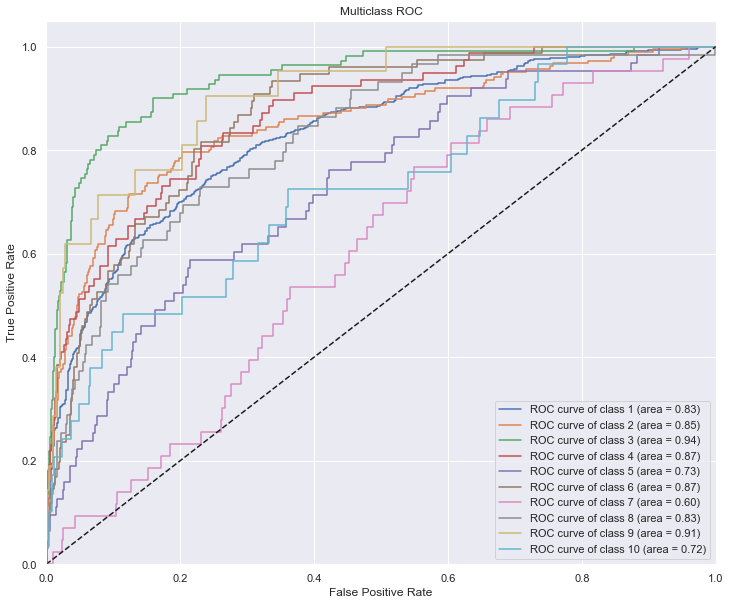

              precision    recall  f1-score   support

           1       0.68      0.84      0.75       644
           2       0.60      0.57      0.58       186
           3       0.63      0.58      0.61       110
           4       0.59      0.38      0.47        78
           5       0.22      0.19      0.20        63
           6       0.32      0.24      0.27        76
           7       0.00      0.00      0.00        43
           8       0.35      0.14      0.20        59
           9       0.24      0.24      0.24        21
          10       0.25      0.10      0.15        29

   micro avg       0.60      0.60      0.60      1309
   macro avg       0.39      0.33      0.35      1309
weighted avg       0.56      0.60      0.57      1309

Accuracy:  0.6027501909854851
Balanced Accuracy:  0.32839487714508386


In [12]:
X_red_train = np.delete(X_train,remove_features,axis=1)
X_red_test = np.delete(X_test,remove_features,axis=1)
print("Training and testing the original features:")
pred_labels, pred_labels_score = lu.XGB_Predict(bst,X_test,y_test)
vu.ROC_curve(y_test,pred_labels_score, fig_size=(12,10))
vu.performance_report(y_test,pred_labels)
print("Training and testing the reduced features:")
bst_red = lu.Learn_XGBoost(X_red_train,y_train,X_red_test,y_test,max_depth=500,num_round=50,use_weights=False)
pred_labels_red, pred_labels_score_red = lu.XGB_Predict(bst_red,X_red_test,y_test)
vu.ROC_curve(y_test,pred_labels_score_red, fig_size=(12,10))
vu.performance_report(y_test,pred_labels_red)

As can be shown, the removal of low variance-low "gini-importance" features did not drastically affect the performance of the classification. However, the slight decline in performance, off approx. 0.5% in accuracy of that small of a number of features dropped suggests that even the low-important features have some effect on the classification. In order to avoid loss of important information, more sophisticated dimensionality techniques might be used instead. 

## 3. Methods and experiments

*- Explain your whole approach (you can include a block diagram showing the steps in your process).* 

*- What methods/algorithms, why were the methods chosen. *

*- What evaluation methodology (cross CV, etc.).*



## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [13]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *